# QAOA を利用して、組合せ最適化問題を解く

このチュートリアルでは、組合せ最適化問題を紹介し、近似最適化アルゴリズムの説明、Quantum Approximate Optimization Algorithm (QAOA)の動作説明、及びシミュレーターもしくは実際の量子システムで動作する実装例の紹介をします。

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

## 組合せ最適化問題

組合せ最適化問題とは、有限個のオブジェクトセットから最適なオブジェクトを見つけ出す問題です。有限個のビット列の中から、0と1で構成される「最適な」ビット列を見つける問題に注目します。グラフに対応するこのような問題の一つに、Max-cut問題があります。

### Max-Cut問題
Max-Cut問題とは、グラフのノードを2つのセットに分割し、そのセット間のエッジの数が最大となるようにする問題です。以下の例では、4つのノードを持つグラフで、「赤」と「青」の2つのセットに分割する方法をいくつか示しています。

![](images/qaoa_maxcut.svg)

4個のノードに対して、各ノードは「赤」と「青」のどちらかのセットに割り当てられるので、割り当ての可能性は $2^4=16$ あり、その中から「赤」と「青」のセット間の辺の数が最大となるものを探さなければなりません。図中の2つのセットの間の辺の数は、左から順に、0, 2, 2, 4です。考えられる $2^4=16$ の割り当てをすべて列挙した結果、一番右の図が、2つのセットの間の辺の数が最大になる割り当てであることがわかります。したがって、「赤」を0、「青」を1としてエンコードすると、どちらかのセットにノードを割り当てることを表すビット列「0101」「1010」が解となります。

お気づきのように、グラフのノード数が増えれば増えるほど、解を求めるために調べなければならない割り当ての可能性が指数関数的に増えていくのです。

## QAOA

Farhi et al.[1]が発表したQAOA (Quantum Approximate Optimization Algorithm) は、このような組合せ問題を解決しようとする量子アルゴリズムです。

これはパラメーター $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ で特徴付けられるユニタリー $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ を用いて量子状態 $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ を準備する変分法的アルゴリズムです。
アルゴリズムの目的は、量子状態`{latex} \lvert \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle`が問題の解をエンコードするような最適なパラメーター`{latex} (\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}})`を見つけることです。

ユニタリー $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ は特定のフォームを持ち、2つのユニタリー $U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ と $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$ で構成されています。ここで、$H_B$ はミキシングハミルトン、$H_P$ は問題ハミルトニアンです。このようなユニタリーの選択は、量子アニーリングと呼ばれる関連スキームからインスピレーションを得ています。

これらのユニタリーを、2つのユニタリーを交互に $p$ 回適用したブロックとして、以下のように適用し、次のような状態を準備します。

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) 
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} 
\lvert \psi_0 \rangle$$

ここで、$\lvert \psi_0 \rangle$ は適当な初期状態です。

これらのステップを、上述したMax-Cut問題を用いて説明します。そのために、我々はまず、上に示した問題の基礎となるグラフを定義することになります。

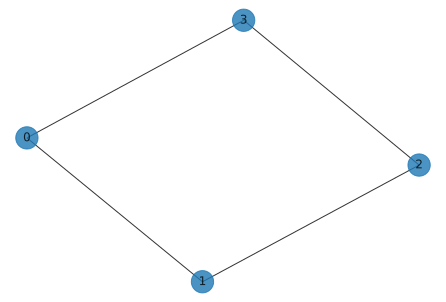

In [2]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

ここで、定数を除いて、Max-Cut問題に特有の問題ハミルトニアンは次の通りです。

$$
H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) + 
        \frac{1}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) +
        \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_3\big) +
        \frac{1}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big)
$$

このようなハミルトニアンを問題に対して構築するためには、このページの後のセクションで説明するいくつかのステップを踏む必要があります。

ミキサーハミルトニアン $H_B$ は通常、次のようなフォームです。

$$
H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) + 
      \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big)
$$

$H_P$ と $H_B$ の和の個々の項がともに交換するので、ユニタリーを次のように書くことができます。

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3}.$$

上の積の各項は、各量子ビットのX回転に対応することに注意してください。そして、$U(H_P)$ を次のように書くことができます。

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_3}$$

では、2つのユニタリーの回路がどのようなものかを見てみましょう。

### ミキシングユニタリー

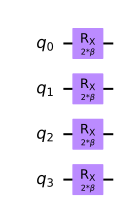

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

### 問題ユニタリー

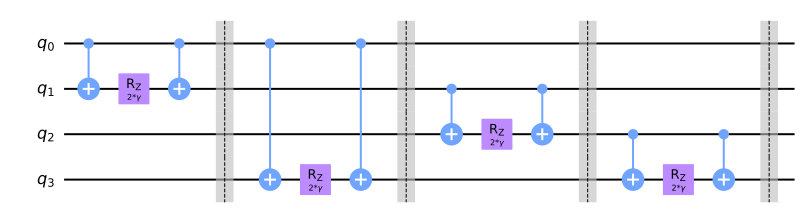

In [4]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

### 初期状態

QAOAで使用される初期状態は、通常、すべての基底状態の等しい重ね合わせです。つまり、

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

このような状態は、量子ビットの数が4 ($n=4$)のとき、以下の回路に示すように、すべてゼロの状態からアダマールゲートを適用して準備することができます。

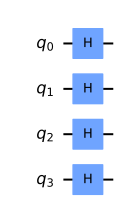

In [5]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

### QAOAの回路

これまで、QAOA時の量子状態の準備は、次の3つの要素で構成されていることを見てきました。
- 初期状態の準備
- 問題ハミルトニアンに対応するユニタリー`{latex} U(H_P) = e^{-i \gamma H_P}`の適用
- そして、ミキシングユニタリー`{latex} U(H_B) = e^{-i \beta H_B}`の適用

例題に対して、どのように見えるか見てみましょう。

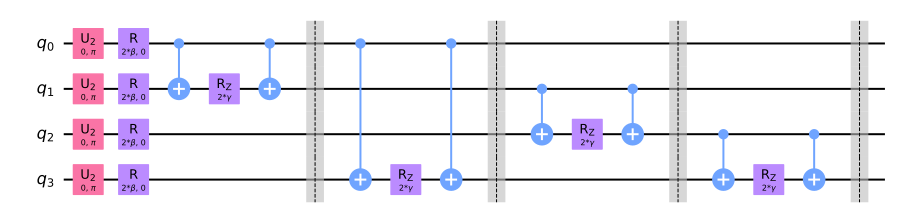

In [6]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

次のステップでは、期待値

$$ \langle \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rvert H_P \lvert 
\psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle $$

が最小になるような最適なパラメーター`{latex} (\boldsymbol{\beta_{\text{opt}}}, \boldsymbol{\gamma_{\text{opt}}})`を探します。このような期待値は、Z基底で測定を行うことで得ることができます。最適なパラメーターを見つけるために、古典的な最適化アルゴリズムを使用する。模式図に示すように、以下のステップが含まれます。
is minimized. Such an expectation can be obtained by doing measurement in the Z-basis. We use a classical optimization algorithm to find the optimal parameters. Following steps are involved as shown in the schematic

<img src="images/QAOA_schematic.png" width="400" height="200" class="center">

1. AとBを適当な実数値に初期化する。Initialize $\boldsymbol{\beta}$ and $\boldsymbol{\gamma}$ to suitable real values.
2. 何らかの適切な収束基準が満たされるまで繰り返す。Repeat until some suitable convergence criteria is met:
    1. qaoa circuitを使って $lvert \psi(\boldsymbol{beta}, \boldsymbol{gamma}) \rangle$ の状態を準備する。Prepare the state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ using qaoa circuit
    2. 状態を標準ベースで測定するMeasure the state in standard basis
    3. Compute $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $ 
    4. 新しいパラメータ `{latex} (\boldsymbol{beta}_{new}, \boldsymbol{gamma}_{new})` を古典的最適化アルゴリズムで求める。Find new set of parameters `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})` using a classical optimization algorithm
    5. 現在のパラメータ $(\boldsymbol{beta}, \boldsymbol{gamma})$ を新しいパラメータと同じにする。Set current parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ equal to the new parameters 
      `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})`

以下のコードは、上記のステップを実装したものです。
The code below implements the steps mentioned above.

In [7]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [8]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

qiskitには古典的最適化手法の異なる選択肢が存在することに注意してください。ここでは古典的最適化アルゴリズムとして[COBYLA](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py)を選びます。
Note that different choices of classical optimizers are present in qiskit. We choose [COBYLA](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py) as our classical optimization algorithm here.

### 結果の分析Analyzing the result

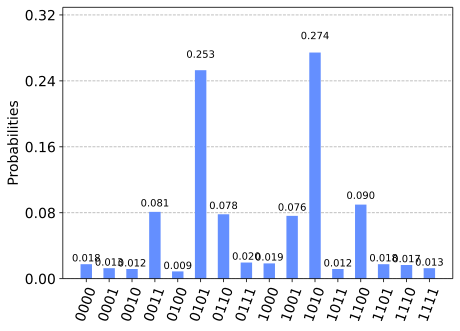

In [9]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

ビット列 "0101 "と "1010 "は最も確率が高く、2つのパーティションの間に4本のエッジを与えるグラフ（最初に作った）の割り当てであることに気づきます。
As we notice that the bitstrings "0101" and "1010" have the highest probability and are indeed the assignments of the graph (we started with) that gives 4 edges between the two partitions. 

## 付録Appendix

### 1. 問題のハミルトニアンの構築Constructing Problem Hamiltonian <a id='Constructing Hamiltonian'></a>

最大化問題は最小化問題で、最小化問題は最小化問題で表現される。したがって、組合せ最適化問題の一般形は次式で与えられる。
Any maximization problem can be cast in terms of a minimization problem and vice versa. Hence the general form a combinatorial optimization problem is given by



$$ \text{maximize } \;\;      C(x)$$




$$ \text{subject to } \;\; x \in S $$



ここで、$x \in S$、は離散変数、$C : D \rightarrow \mathbb{R}$ はコスト関数で、ある領域$S$から実数$mathbb{R}$に写すものである。変数$x$は制約を受けることができ、実行可能点のセット$S \subset D$の中にある。
where $x \in S$, is a discrete variable and $C : D \rightarrow \mathbb{R}$ is the cost function, that maps from some domain $S$ in to the real numbers $\mathbb{R}$. The variable $x$ can be subject to a set of constraints and lies within the set $S \subset D$ of feasible points.

2値組合せ最適化問題において、コスト関数$C$は、一般に文字列$x \in{0,1}^n$ の$n$ ビットの部分セット$Q \subset[n]$ のみを含む項の和として表現でき、正準形式で書かれます。
In binary combinatorial optimization problems, the cost function $C$ can typically be expressed as a sum of terms that only involve a subset $Q \subset[n]$ of the $n$ bits in the string $x \in \{0,1\}^n$ and is written in the canonical form



$$ C(x) = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \prod_{i\in Q} x_i \; \prod_{j\in \overline{Q}} (1- x_j), $$



ここで、$x_i \in \{0,1}$, $w_{(Q,\overline{Q})}}in \mathbb{R}$ とする。C(x)$ が最大となるnビット文字列$x$を求めたい。
where $x_i \in \{0,1\}$ and $w_{(Q,\overline{Q})}\in \mathbb{R}$. We want to find the n-bit string $x$ for which $C(x)$ is the maximal.

#### 1.1 対角ハミルトニアンDiagonal Hamiltonians

このコスト関数は、計算基底において対角となるハミルトニアンに写像することができる。コスト関数$C$が与えられると、このハミルトニアンは次のように書かれる。
This cost function can be mapped to a Hamiltonian that is diagonal in the computational basis. Given the cost-function $C$ this Hamiltonian is then written as



$$ H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x| $$



ここで、$x \in \{0,1}^n$ は計算基底状態$|x \in \mathbb{C}^{2^n}$ をラベル付けしています。コスト関数がせいぜいweight $k$ 項しか持たない場合、すなわちせいぜい$Q \leq k$ビットを含む$Q$寄与しかない場合、この対角ハミルトニアンはweight $k$ Pauli $Z$演算子の和にしかならない。
where $x \in \{0,1\}^n$ labels the computational basis states $|x \rangle \in \mathbb{C}^{2^n}$. If the cost function only has at most weight $k$ terms, i.e. when only $Q$ contribute that involve at most $Q \leq k$ bits, then this diagonal Hamiltonian is also only a sum of weight $k$ Pauli $Z$ operators.

H$ の Pauli $Z$ 演算子への展開は、コスト関数 $C$ の正準展開から、すべての二項変数 $x_i \in \in {0,1}$ に行列 `{latex} x_i 2^{-1}(1 - Z_i)` を代入して得ることができる。ここで、$Z_i$は量子ビット$i$に作用するPauli $Z$演算子で、それ以外には三値であると読みます。
The expansion of $H$ in to Pauli $Z$ operators can be obtained from the canonical expansion of the cost-function $C$ by substituting for every binary variable $x_i \in \{0,1\}$ the matrix `{latex} x_i \rightarrow 2^{-1}(1 - Z_i)`. Here $Z_i$ is read as the Pauli $Z$ operator that acts on qubit $i$ and trivial on all others, i.e.



$$ Z_i = \left(\begin{array}{cc} 1 & 0 \\ 0 & -1 \end{array}\right). $$



これは、古典的なコスト関数をエンコードするスピンハミルトニアンが、パウリ$Z$-演算子のみを含む$|Q|$ -局所量子スピンハミルトニアンとして書かれていることを意味します。
This means that the spin Hamiltonian encoding the classical cost function is written as a $|Q|$ - local quantum spin Hamiltonian only involving Pauli $Z$- operators. 



$$ H = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \frac{1}{2^{|Q| + |\overline{Q}|}}\prod_{i\in Q} \left(1 - Z_i\right) \; \prod_{j\in \overline{Q}} \left(1 + Z_j\right).$$



ここで、$w_{(Q, \overline{Q})}$ が0でないのは少数（$n$で多項式）であると仮定します。また、セット $|(Q,\overline{Q})|$ は有界であまり大きくないものとします。これは、コスト関数だけでなくハミルトニアン$H$も$m$個の局所項$hat{C}_k$の和として書けることを意味します。
Now, we will assume that only a few (polynomially many in $n$) $w_{(Q,\overline{Q})}$ will be non-zero. Moreover we will assume that the set $|(Q,\overline{Q})|$ is bounded and not too large. This means we can write the cost function as well as the Hamiltonian $H$ as the sum of $m$ local terms $\hat{C}_k$, 



$$ H = \sum_{k = 1}^m \hat{C}_k, $$



ここで、$m$と$Θhat{C}_k$のサポートはともに合理的に束縛されています。
where both $m$ and the support of $\hat{C}_k$ is reasonably bounded.

### 2 事例紹介Examples: <a id='examples'></a>

組合せ最適化問題を説明するために、2つの例について考える。Qiskitのように最初の例だけを実装し、2番目の例も実装するための手順を示す一連の演習を提供する。
We consider 2 examples to illustrate combinatorial optimization problems. We will only implement the first example as in Qiskit, but provide a sequence of exercises that give the instructions to implement the second example as well.  


#### 2.1 (weighted) $MAXCUT$

n$ ノードの無向グラフ *G = (V, E)* (*|V| = n*) で、辺の重みが $w_{ij}>0$, `{latex} w_{ij}=w_{ji}`, for $(i,j)\in E$ であるものとする。カットとは、元のセットVを2つの部分セットに分割することである。最適化されるコスト関数は、この場合、2つの異なる部分セットの点を結ぶ辺の重みの合計であり、カットを*横切る。各ノード$i$に$x_i=0$または$x_i=1$を割り当てることにより、大域的利益関数を最大化しようとする（以下、添字1,2,...,nについて総和をとる）。
Consider an $n$-node non-directed graph *G = (V, E)* where *|V| = n* with edge weights $w_{ij}>0$, `{latex} w_{ij}=w_{ji}`, for $(i,j)\in E$. A cut is defined as a partition of the original set V into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, *crossing* the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$, one tries to maximize the global profit function (here and in the following summations run over indices 1,2,...,n)



$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j).$$



表記を簡単にするため、$(i,j) \in E$に対して一様な重み$ w_{ij} = 1$を仮定する。量子コンピュータでこの問題の解を求めるには、まず、上で述べたように対角ハミルトニアンに写像する必要があります。セット $(i,j) = E$ に含まれる辺の総和として書きます。
To simplify notation, we assume uniform weights $ w_{ij} = 1$ for $(i,j) \in E$. In order to find a solution to this problem on a quantum computer, one needs first to map it to a diagonal  Hamiltonian as discussed above. We write the sum as a sum over edges in the set $(i,j) = E$ 



$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j)  = \sum_{(i,j) \in E} \left( x_i (1-x_j) + x_j (1-x_i)\right)$$



スピンハミルトニアンへの写像は、$Z_i$を固有値$pm 1$とするPauli Z演算子として、`{latex} x_irightarrow (1-Z_i)/2` とし、$X \rightarrow H$を得ます。
To map it to a spin Hamiltonian, we make the assignment `{latex} x_i\rightarrow (1-Z_i)/2`, where $Z_i$ is the Pauli Z operator that has eigenvalues $\pm 1$ and obtain $X \rightarrow H$



$$ H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_j Z_k \right).$$



これは、ハミルトニアンが $m = |E|$ の局所項の和として書けることを意味する。
This means that the Hamiltonian can be written as a sum of $m = |E|$ local terms:

$$\hat{C}_e = \frac{1}{2}\left(1 - Z_{e1}Z_{e2}\right)$$

with $e = (e1,e2) \in E$. 


#### 2.2 制約充足問題と$text{MAX 3-SAT}$ の関係Constraint satisfaction problems and $\text{MAX 3-SAT}$.

組合せ最適化問題の他の例として、$text{3-SAT}$がある。ここで、コスト関数 `{latex} は次のようになります。C(\textbf{x}) = \sum_{k = 1}^m c_k(\textbf{x})` は、ある $c_k(\textbf{x})$ 節の$3$ ビットの値を拘束する和であり、その節に参加するある $tempbf{x} の $tempbf{f}$ ビットは、$c_k(dsum)$ と $tempb{f{x}$ の和である。\の$3$ビットの値を制約する句$c_k(textbf{x})$の総和です。例えば、$text{3-SAT}$節の例を見てみましょう。
Another example of a combinatorial optimization problem is $\text{3-SAT}$. Here the cost function `{latex} C(\textbf{x}) = \sum_{k = 1}^m c_k(\textbf{x})` is a sum of clauses $c_k(\textbf{x})$ that constrain the values of $3$ bits of some $\textbf{x} \in \{0,1\}^n$ that participate in the clause. Consider for instance this example of a $\text{3-SAT}$ clause 



$$ c_1(\textbf{x}) = (1-x_1)(1-x_3)x_{132} $$



for a bit string $textbf{x} \を満たす。この節は、ビット$x_1 = 0$,$x_3 = 0$,$x_{132} = 1$を設定することによってのみ満たすことができる。ここで、$text{3-SAT}$問題は、$m$個の句をすべて満たすビット列があるか、あるいは、そのようなビット列が存在しないかを問う。この決定問題は、$NP$完全である問題の代表例である。
for a bit string $\textbf{x} \in \{0,1\}^{133}$. The clause can only be satisfied by setting the bits $x_1 = 0$,$x_3 = 0$ and $x_{132} = 1$. The $\text{3-SAT}$ problem now asks whether there is a bit string that satisfies all of the $m$ clauses or whether no such string exists. This decision problem is the prime example of a problem that is $NP$-complete.  

密接に関連する最適化問題$text{MAX 3-SAT}$ は、$C(textbf{x})$の最大数の句を満たすビット列$textbf{x}$を求めるものである。もちろん、$m$個の節のうち$tilde{m}$個以上を満たすビット列がどこに存在するかを問えば、再び決定問題となり、これも$NP$-completeとなる。
The closely related optimization problem $\text{MAX 3-SAT}$ asks to find the bit string $\textbf{x}$ that satisfies the maximal number of of clauses in $C(\textbf{x})$. This can of course be turned again in to a decision problem if we ask where there exists a bit string that satisfies more than $\tilde{m}$ of the $m$ clauses, which is again $NP$-complete.

### 3. 近似最適化アルゴリズムApproximate optimization algorithms <a id='approximateOPT'></a>

以前検討した$MAXCUT$と$text{MAX 3-SAT}$の両問題は、実はNP困難問題であることが知られています[3](#references). 実際、多くの組合せ最適化問題は一般に計算困難であることが分かっています。このことから，証明可能な効率的アルゴリズム，すなわち，問題サイズに対して多項式実行時間を持つアルゴリズムで，これらの問題を解くことは期待できません．このことは、量子アルゴリズムにも当てはまります。このような問題に対処するためには、大きく分けて2つのアプローチがあります。一つは近似アルゴリズムで、指定された品質の解を多項式時間で求めることが保証されています。もう一つは、多項式時間での実行は保証されていないが、このような問題のいくつかのインスタンスで良好な性能を示すと思われるヒューリスティックアルゴリズムである。
Both the previously considered problems $MAXCUT$ and $\text{MAX 3-SAT}$ are actually known to be a NP-hard problems [3](#references). In fact it turns out that many combinatorial optimization problems are computationally hard to solve in general. In light of this fact, we can't expect to find a provably efficient algorithm, i.e. an algorithm with polynomial runtime in the problem size, that solves these problems. This also applies to quantum algorithms. There are two main approaches to dealing with such problems. First approach is approximation algorithms that are guaranteed to find solution of specified quality in polynomial time. The second approach are heuristic algorithms that don't have a polynomial runtime guarantee but appear to perform well on some instances of such problems. 

近似最適化アルゴリズムは効率的であり、近似解が問題の実際の最適解にどれだけ近いかを証明できる保証を提供します。この保証は、一般に近似比$alpha \leq 1$の形で提供される。確率的近似最適化アルゴリズムでは、ビット列$textbf{x}^*を生成する際に、高確率で*正`{latex}で次のようになることを保証しています。C_text{max} = \max_{Textbf{x}}C(\textbf{x})` となります。
Approximate optimization algorithms are efficient and provide a provable guarantee on how close the approximate solution is to the actual optimum of the problem. The guarantee typically comes in the form of an approximation ratio, $\alpha \leq 1$. A probabilistic approximate optimization algorithm guarantees that it produces a bit-string $\textbf{x}^* \in \{0,1\}^n$ so that *with high probability* we have that with a positive `{latex} C_\text{max} = \max_{\textbf{x}}C(\textbf{x})` 



$$ C_\text{max} \geq C(\textbf{x}^*) \geq \alpha C_\text{max}. $$



MAXCUT$問題には，GoemansとWilliamsonによる有名な近似アルゴリズムがある[2](#references) ．このアルゴリズムは、元問題のSDP緩和と確率的丸め技術に基づいており、高確率で近似解 $textbf{x}^*$ が得られ、その近似比は $alpha \approx 0.878$ である。この近似解は実は最適解と考えられており、量子アルゴリズムによる改善は期待できない。
For the $MAXCUT$ problem there is a famous approximate algorithm due to Goemans and Williamson [2](#references) . This algorithm is based on an SDP relaxation of the original problem combined with a probabilistic rounding technique that yields an with high probability approximate solution $\textbf{x}^*$ that has an approximation ratio of $\alpha \approx 0.878$. This approximation ratio is actually believed to optimal so we do not expect to see an improvement by using a quantum algorithm.

### 4. QAOAアルゴリズムThe QAOA algorithm <a id="QAOA"></a>
Farhi, Goldstone and Gutmannによる量子近似最適化アルゴリズム(QAOA) [1](#references)は、ヒューリスティック・アルゴリズムの一例である。Goemans-Williamsonアルゴリズムとは異なり、QAOAには性能保証がありません。
QAOAは古典的な近似アルゴリズムの考え方を取り入れ，同様に高確率で良い近似率$alpha$が期待できる古典的なビット列$x^*$を生成する量子アナログを探します．詳細を説明する前に、まずこのアプローチの一般的な考え方を紹介します。
The Quantum approximate optimization algorithm (QAOA) by Farhi, Goldstone and Gutmann [1](#references) is an example of a heuristic algorithm. Unlike Goemans-Williamson algorithm, QAOA does not come with performance guarantees.
QAOA takes the approach of classical approximate algorithms and looks for a quantum analogue that will likewise produce a classical bit string $x^*$ that with high probability is expected to have a good approximation ratio $\alpha$. Before discussing the details, let us first present the general idea of this approach. 

#### 4.1 概要Overview:

We want to find a quantum state $|psi_p(\vec{gamma},\vec{beta})\rangle$, that depends on some real parameters $vec{gamma},\vec{beta} \inmathbb{R}^p$, which has maximizes the expectation value with respect to the problem Hamiltonian $H$. この試行状態が与えられたら、`{latex}を最大化するパラメータ$vec{}gamma}^*, \vec{}beta}^*$ を探索する。F_p(\vec{gamma},\vec{beta}) = \langle \psi_p(\vec{gamma},\vec{beta})|H|psi_p(\vec{gamma},\vec{beta})\rangle` を最大化するパラメータを探索します。
We want to find a quantum state $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$, that depends on some real parameters $\vec{\gamma},\vec{\beta} \in \mathbb{R}^p$, which has the property that it maximizes the expectation value with respect to the problem Hamiltonian $H$. Given this trial state we search for parameters $\vec{\gamma}^*,\vec{\beta}^*$ that maximize `{latex} F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle`. 

このような状態とそれに対応するパラメータがあれば、量子コンピュータ上で $|psi_p(\vec{Gamma}^*,\vec{Beta}^*)\rangle$ という状態を用意し、$Z$基底で状態を測定して `{latex}. |x \rangle = |x_1,\ldots x_n \rangle` で測定し、ランダムな結果 $x^*$ を得ます。
Once we have such a state and the corresponding parameters we prepare the state $|\psi_p(\vec{\gamma}^*,\vec{\beta}^*)\rangle$ on a quantum computer and measure the state in the $Z$ basis `{latex} |x \rangle = |x_1,\ldots x_n \rangle` to obtain a random outcome $x^*$. 

このランダムな$x^*$は、高確率で期待値 `{latex} に近いビット列になることが分かる。M_p = F_p(\vec{Thomasgamma}^*,\vec{Thomasbeta}^*)` となることがわかります。したがって、$M_p$が$C_text{max}$に近ければ、$C(x^*)$も近いです。
We will see that this random $x^*$ is going to be a bit string that is with high probability close to the expected value `{latex} M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)`. Hence, if $M_p$ is close to $C_\text{max}$ so is $C(x^*)$.

#### 4.2 QAOAアルゴリズムの構成要素。The components of the QAOA algorithm.

#### 4.2.1 QAOA試験状態The QAOA trial state <a id="section_421"></a>
QAOAの中心は、量子コンピュータに用意される試行状態$|psi_p( \vec{gamma},\vec{beta})\rangle$ です。この状態から大きな期待値 `{latex}} が得られることが理想です。F_p(\vec{gamma},\vec{beta}) = \langle \psi_p(\vec{gamma},\vec{beta})|H|psi_p(\vec{gamma},\vec{beta})\rangle` with respect to the problem Hamiltonian $H$となります。Farhi [1](#参考文献)では、試行状態$|psi_p( \vec{gamma},\vec{beta})\rangle$ は問題のハミルトニアン$H$と単一量子ビットパウリ$X$回転から構成されています。つまり、問題ハミルトニアンが与えられると
Central to QAOA is the trial state $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ that will be prepared on the quantum computer. Ideally we want this state to give rise to a large expectation value `{latex} F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle` with respect to the problem Hamiltonian $H$. In Farhi [1](#references), the trial states $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ are constructed from the problem Hamiltonian $H$ together with single qubit Pauli $X$ rotations. That means, given a problems Hamiltonian 


$$ H = \sum_{k = 1}^m \hat{C}_k $$

 
計算基底で対角化し、横磁場ハミルトニアン
diagonal in the computational basis and a transverse field Hamiltonian


$$ B = \sum_{i = 1}^n X_i $$


試行状態は、$p$個の交互ユニタリーを適用して準備される。
the trial state is prepared by applying $p$ alternating unitaries 



$$ |\psi_p(\vec{\gamma},\vec{\beta})\rangle = e^{ -i\beta_p B } e^{ -i\gamma_p H } \ldots e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+\rangle^n $$



を積状態 $|+rangle^n$ で $ X |+³³ = |+³³rangle$ とする。
to the product state $|+\rangle^n$ with $ X |+\rangle = |+\rangle$. 

この特殊なansatzには、$vec{gamma}^*, \vec{beta}^*$ for `{latex}に対して、以下のようなベクトルの明示的な選択が存在する、という利点があります。M_p = F_p(\vec{Gamma}^*,\vec{Beta}^*)` for the limit `{latex} when we take the limit `{latex}. \M_p = C_text}、M_p = C_text}、M_p = C_text}、M_p = C_text}。M_p = C_text{max}` となります。これは、試行状態 $|psi_p(\vec{gamma},\vec{beta}) \rangle$ を、$H$ と横磁場ハミルトニアン $B$ に関して断熱進化をトロット化した状態として見ることにより、導かれます(#参考文献[1])。
This particular ansatz has the advantage that there exists an explicit choice for the vectors $\vec{\gamma}^*,\vec{\beta}^*$ such that for `{latex} M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)` when we take the limit `{latex} \lim_{p \rightarrow \infty} M_p = C_\text{max}`. This follows by viewing the trial state $|\psi_p(\vec{\gamma},\vec{\beta}) \rangle$ as the state that follows from trotterizing the adiabatic evolution with respect to $H$ and the transverse field Hamiltonian $B$, c.f. Ref [1](#references).

逆に、この試行状態の欠点は、量子回路から生成された状態が、あまり深くないことを望むことである。ここでいう深さとは、量子チップに直接適用可能なゲートの深さを指す。そのため、量子チップのハードウェアに合わせたアンサッツトライアルステートを使用することを提案する他の提案もあります。[4](#references)、Ref. [5](#references)を参照してください。
Conversely the disadvantage of this trial state is one would typically want a state that has been generated from a quantum circuit that is not too deep. Here depth is measured with respect to the gates that can be applied directly on the quantum chip. Hence there are other proposals that suggest using Ansatz trial state that are more tailored to the Hardware of the quantum chip Ref. [4](#references), Ref. [5](#references).


#### 4.2.2 期待値の計算Computing the expectation value <a id="section_422"></a>
この手法の重要な要素は、期待値を計算または推定する必要があることです。
An important component of this approach is that we will have to compute or estimate the expectation value 

$$
F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle 
$$

というように、パラメータ $vec{gamma},\vec{beta}$ を最適化することができます。ここでは、2つのシナリオを考える。
so we can optimize the parameters $\vec{\gamma},\vec{\beta}$. We will be considering two scenarios here. 

#### 古典的な評価Classical evaluation
なお、$|psi_p( \vec{gamma},\vec{beta})\rangle$ を準備する回路があまり深くない場合は、期待値$F_p$ を古典的に評価できる場合があります。
Note that when the circuit to prepare $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ is not too deep it may be possible to evaluate the expectation value $F_p$ classically.  

これは例えば、有界次数のグラフに対して$MAXCUT$を考え、$p=1$の回路を考えるときに起こる。以下のQiskitの実装（5.2節）でこの例を見て、期待値を計算する演習を行う。
This happens for instance when one considers $MAXCUT$ for graphs with bounded degree and one considers a circuit with $p=1$. We will see an example of this in the Qiskit implementation below (section 5.2) and  provide an exercise to compute the expectation value.

ハミルトニアンは個々の項の和として書けることを思い出してください。H = \sum_{k = 1}^m \hat{C}_k` と書くことができることを思い出してください。期待値の線形性から、個々の和の期待値を考えるだけで十分である。p = 1$ のとき、次のようになる。
To illustrate the idea, recall that the Hamiltonian can be written as a sum of individual terms `{latex} H = \sum_{k = 1}^m \hat{C}_k`. Due to the linearity of the expectation value, it is sufficient to consider the expectation values of the individual summands. For $p = 1$ one has that 



$$ \langle \psi_1(\vec{\gamma},\vec{\beta})|\hat{C}_k|\psi_1(\vec{\gamma},\vec{\beta})\rangle =  \langle +^n | e^{ i\gamma_1 H } e^{   i\beta_1 B } | \hat{C}_k |  e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+^n\rangle.$$



latex}で観察してください。B = \sum_{i = 1}^n X_i` で、ユニタリー $e^{ -ibeta_1 B }$ は実際には $X$ についてのシングル量子ビットの角度 $beta$ の回転の積で、これを `{latex} と書きます。X(\beta)_k = \exp(iⅫbeta X_k)`と書きます。
Observe that with `{latex} B = \sum_{i = 1}^n X_i` the unitary $e^{ -i\beta_1 B }$ is actually a product of single qubit rotations about $X$ with an angle $\beta$ for which we will write `{latex} X(\beta)_k = \exp(i\beta X_k)`. 

このとき、$hat{C}_k$がサポートされている量子ビットに作用しない個々の回転はすべて$hat{C}_k$と交わりますので、キャンセルされます。これは、演算子$Θhat{C}_k$の支持を増加させない。これは、ユニタリーゲートの第2セット `{latex} e^{ -iathygamma_1 H }. = \prod_{l=1}^m U_l(\gamma)` は、大きなゲートセット `{latex} を持つことになります。U_l(\gamma) = e^{ -igamma_1 \hat{C}_l }` that commute with the operator `{latex} e^{ ibeta_1 B } } }. \hat{C}_k e^{ -ièmebeta_1 B }` と交わる。唯一のゲート `{latex} は U_l(\gamma) = e^{ -igamma_1 \hat{C}_l }`で期待値に寄与するのは、元の$hat{C}_k$のサポートにある量子ビットに関与するものだけです。
All the individual rotations that don't act on the qubits where $\hat{C}_k$ is supported commute with $\hat{C}_k$ and therefore cancel. This does not increase the support of the operator $\hat{C}_k$. This means that the second set of unitary gates `{latex} e^{ -i\gamma_1 H } = \prod_{l=1}^m U_l(\gamma)` have a large set of gates `{latex} U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }` that commute with the operator `{latex} e^{ i\beta_1 B } \hat{C}_k  e^{ -i\beta_1 B }`. The only gates `{latex} U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }` that contribute to the expectation value are those which involve qubits in the support of the original $\hat{C}_k$. 

したがって、bounded degree interactionでは、`{latex} e^{ igamma_1 H } e^{ ibeta_1 B } のsupportは、$H$における相互作用の次数で与えられる量だけ拡大し、$H$における相互作用の次数で与えられる量だけ拡大する。\hat{C}_k e^{ -iŏbeta_1 B } e^{ -iŏgamma_1 H }` は $H$ における相互作用の程度で与えられる量だけ拡大し、したがってシステムサイズに依存しない。つまり、これらの小さな部分問題では期待値は$n$に依存せず、古典的に評価することができる。一般的な次数 $3$ の場合については、[1](#references) で考察されている。
Hence, for bounded degree interaction the support of `{latex} e^{ i\gamma_1 H } e^{   i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B } e^{ -i\gamma_1 H }` only expands by an amount given by the degree of the interaction in $H$ and is therefore independent of the system size. This means that for these smaller sub problems the expectation values are independent of $n$ and can be evaluated classically. The case of a general degree $3$ is considered in [1](#references).

これは一般的な観測であり、試行状態の準備に用いる回路がハミルトニアンの各項の支持を一定量だけ増やすような問題であれば、コスト関数を直接評価することができることを意味している。
This is a general observation,  which means that if we have a problem where the circuit used for the trial state preparation only increases the support of each term in the Hamiltonian by a constant amount the cost function can be directly evaluated. 

このとき、試行状態の準備に必要なパラメータは$beta, \gamma$だけである。
が必要な場合、簡単なグリッドサーチで見つけることができる。さらに、$M_p$の正確な最適値を用いて、近似比
When this is the case, and only a few parameters $\beta, \gamma$ are needed in the preparation of the trial state,
these can be found easily by a simple grid search. Furthermore, an exact optimal value of $M_p$ can be used to bound the approximation ratio



$$ \frac{M_p}{C_\text{max}} \geq \alpha $$



を計算し、$alpha$の推定値を得る。この場合、QAOAアルゴリズムは、問題サイズの多項式効率で得られる近似比が保証された従来の近似最適化アルゴリズムと同じ特徴を持つ。
to obtain an estimate of $\alpha$. For this case the QAOA algorithm has the same characteristics as a conventional approximate optimization algorithm that comes with a guaranteed approximation ratio that can be obtained with polynomial efficiency in the problem size.


#### 量子コンピュータでの評価Evaluation on a quantum computer

量子回路が深くなりすぎて古典的に評価できない場合や、問題のハミルトニアンの接続性が高すぎる場合は、他の方法で期待値を推定することができます。これは、量子コンピュータ上で$F_p( \vec{gamma},\vec{beta})$ を直接推定するものです。ここでは、VQE[4](#references)で用いられている従来の期待値推定の経路を踏襲し、量子コンピュータ上で試行状態$| \psi_p(\vec{gamma},\vec{beta}) \rangle$を直接用意し、サンプリングから期待値を得ます。
When the quantum circuit becomes too deep to be evaluated classically, or when the connectivity of the Problem Hamiltonian is too high we can resort to other means of estimating the expectation value. This involves directly estimating $F_p(\vec{\gamma},\vec{\beta})$ on the quantum computer. The approach here follows the path of the conventional expectation value estimation as used in VQE [4](#references), where a trial state $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle$ is prepared directly on the quantum computer and the expectation value is obtained from sampling.

QAOAは対角ハミルトニアン$H$を持つので、実は期待値を推定するのは簡単である。計算基底の試行状態からサンプルを取得すればよいのです。H = \sum_{x｜in｜{0,1}^n} であることを想起してください。C(x) |x \rangle x|$ であることを思い出し、そのサンプリング推定値を求めます。
Since QAOA  has a diagonal Hamiltonian $H$ it is actually straight forward to estimate the expectation value. We only need to obtain samples from the trial state in the computational basis. Recall that $H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x|$ so that we can obtain the sampling estimate of 



$$ \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle = \sum_{x \in \{0,1\}^n} C(x) |\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$$



の1量子計測を繰り返すことにより、$| \psi_p(\vec{gamma},\vec{beta}) \rangle $ in the $Z$ basisを得ることができます。分布$|langle x| \psi_p(\vec{gamma},\vec{beta}) \rangle |^2$から得られる各ビット列$x$について、コスト関数$C(x)$を評価し、全サンプル数で平均化する。得られた経験平均は、状態の分散の範囲内にある加法的なサンプリング誤差まで期待値に近似する。分散については後述します。
by repeated single qubit measurements of the state $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle $ in the $Z$ basis. For every bit string $x$ obtained from the distribution $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ we evaluate the cost function $C(x)$ and average it over the total number of samples. The resulting empirical average approximates the expectation value up to an additive sampling error that lies within the variance of the state. The variance will be discussed below.

期待値が入手できれば、あとは[6](#references)などの古典的な最適化アルゴリズムを実行して、$F_p$を最適化することができるようになります。
With access to the expectation value, we can now run a classical optimization algorithm, such as [6](#references), to optimize the $F_p$.

この方法は$x^*$の近似保証にはつながらないが、最適化された関数値は後で近似比$alpha$の推定値に使用することができる。
While this approach does not lead to an a-priori approximation guarantee for $x^*$, the optimized function value can be used later to provide an estimate for the approximation ratio $\alpha$.


#### 4.3.3 与えられた近似比の解を高い確率で得ることObtaining a solution with a given approximation ratio with high probability
このアルゴリズムは確率的なもので、分布 $|langle x| \psi_p(\vec{gamma},\vec{beta}) \rangle |^2$ からランダムなビット列を生成します。では、最適化された期待値$M_p$の値に近い近似値$x^*$をサンプリングするためにはどうすればよいのでしょうか。そもそもこの疑問は、量子コンピュータで$M_p$を推定する際にも関係することに注意しましょう。もし、$|langle x| \psi_p(\vec{gamma},\vec{beta}) \rangle |^2$ から引いたサンプルの分散が大きすぎると、平均を求めるために多くのサンプルが必要になってしまいます。
The algorithm is probabilistic in nature and produces random bit strings from the distribution $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$. So how can we be sure that we will sample an approximation $x^*$ that is close to the value of the optimized expectation value $M_p$? Note that this question is also relevant to the estimation of $M_p$ on a quantum computer in the first place. If the samples drawn from $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ have too much variance, many samples are necessary to determine the mean. 

変数としてのエネルギーがほとんど分散を持たないとき、高い確率で平均値$M_p$に近いビット列$x^*$を描くことになる。
We will draw a bit string $x^*$ that is close to the mean $M_p$ with high probability when the energy as variable has little variance.

なお、ハミルトニアンの項数 `{latex} は H = \sum_{k=1}^m \hat{C}_k` の項の数は$m$で束縛されることに注意してください。個々の和セット $hat{C}_k$ が、すべての $k = 1}ldots m$ に対して、普遍定数$Θ|Θhat{C}_k| \tilde{C}$ で束縛可能な演算子ノルムを持っているとします。次に、以下を考える。
Note that the number of terms in the Hamiltonian `{latex} H = \sum_{k=1}^m \hat{C}_k` are bounded by $m$. Say each individual summand $\hat{C}_k$ has an operator norm that can be bounded by a universal constant $\|\hat{C}_k\| \leq \tilde{C}$ for all $k = 1\ldots m$. Then consider 

$$
\begin{aligned}
\langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle - \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle^2 &\leq  \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle \\
&= \sum_{k,l =1}^m  \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \\
&\leq m^2 \tilde{C}^2 \\
\end{aligned}
$$


ということを利用したところ 
where we have used that 
`{latex} \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \leq \tilde{C}^2`. 


これは、任意の期待値$F_p( \vec{pamma},\vec{beta})$ の分散が$m^2 \tilde{C}^2$ で束縛されることを意味します。したがって、これは特に $M_p$ について当てはまる。さらに、$m$が量子ビット数$n$に対して多項式に成長するだけなら、$s = Oờngleft(\frac{tilde{C}^2 m^2}{epsilon^2}}right)$ from $|langle x| \psi_p(\vec{Thanka}, \ΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓ ΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓ ΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓΓ
This means that the variance of any expectation $F_p(\vec{\gamma},\vec{\beta})$ is bounded by $m^2 \tilde{C}^2$. Hence this in particular applies for $M_p$. Furthermore if $m$ only grows polynomially in the number of qubits $n$, we know that taking polynomially growing number of samples $s = O\left(\frac{\tilde{C}^2 m^2}{\epsilon^2}\right)$ from $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ will be sufficient to obtain a $x^*$ that leads to an $C(x^*)$ that will be close to $M_p$.

### 5. 問題<a id="problems"></a>

0. QAOAアルゴリズムはビット列を生成しますが、この文字列はこのグラフの最適解となるのでしょうか？超伝導チップの実験結果と、局所的なQASMシミュレーションの結果を比較してみてください。The QAOA algorithm produces a bit string, is this string the optimal solution for this graph? Compare the experimental results from the superconducting chip with the results from the local QASM simulation.


1. 5.2節](#implementation_sec52)で、コスト関数$F_1$を解析的に計算しました。手順を確認し、$f_A( \gamma,\beta)$ と $f_B(\gamma,\beta)$ を計算しなさい。We have computed the cost function $F_1$  analytically in [section 5.2](#implementation_sec52). Verify the steps and compute $f_A(\gamma,\beta)$ as well $f_B(\gamma,\beta)$. 


2. Qiskitの実装で$F_1$の厳密な式を与えている。We have given an exact expression for $F_1$ in the Qiskit implementation. 

      - 結果で得られたサンプルから期待値$F_1( \gamma,\beta)$ を推定するルーチンを書く（ヒント：[5.4節](#implementation_sec54)の関数 cost_function_C(x,G) と [5.a / 5.b](#implementationsim) 両項のデータの評価を使ってください）。Write a routine to estimate the expectation value $F_1(\gamma,\beta)$ from the samples obtained in the result (hint: use the function cost_function_C(x,G) from [section 5.4](#implementation_sec54) and the evaluation of the data in both section [5.a / 5.b](#implementationsim))
       
      - 最適化ルーチン、例えばこのチュートリアルのVQEの例のSPSAを使って、サンプリングされた$F_1( \gamma,\beta)$ のパラメータを数値的に最適化することができます。その結果、$gamma^*, \beta^*$ の値は同じになりましたか？Use an optimization routine,e.g. SPSA from the VQE example in this tutorial, to optimize the parameters in the sampled $F_1(\gamma,\beta)$ numerically. Do you find the same values for $\gamma^*,\beta^*$ ?


3. 5.3節](#implementation_sec53)のTrial回路は深さ$p=1$に対応し、直接Hardwareとの互換性を狙ったものであった。The Trial circuit in [section 5.3](#implementation_sec53) corresponds to depth $p=1$ and was directly aimed at being compatible with the Hardware.
    - 演習2のルーチンを使って、コスト関数 $F_p(\gamma,\beta)$ を $p=2,3$ について評価しなさい。実際のハードウェアでは、どのような結果が期待できますか？Use the routine from exercise 2 to evaluate the cost functions $F_p(\gamma,\beta)$ for $p=2,3$. What do you expect to see in the actual Hardware?
    - このクラスの試行状態を他の波動関数候補に一般化し、例えばRef. [4](#references)のHardware efficient asatzのようなものである。Generalize this class of trial state to other candidate wave functions, such as the Hardware efficient ansatz of Ref. [4](#references).
    

4. 例題の項で説明した$text{MAX 3-SAT}$の例を考え、$F_p$の計算に使用した[5.4節](#implementation_sec54)の関数 cost_function_C(c,G) を適宜修正しなさい。この$text{MAX 3-SAT}$のインスタンスに対して、ハードウェア効率の良いアルゴリズムを用いてQAOAアルゴリズムを実行し、その結果を解析せよ。Consider an example of $\text{MAX 3-SAT}$  as discussed in the example section and modify the function cost_function_C(c,G) from [section 5.4](#implementation_sec54) you have used to compute $F_p$ accordingly. Run the QAOA algorithm for this instance of $\text{MAX 3-SAT}$ using the hardware efficient algorithm and analyze the results. 

## 参考文献<a id="references"></a>
1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table